In [53]:
%pylab inline

import pandas as pd
import nltk
import spacy
import timer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import log_loss, f1_score, jaccard_score, precision_score, recall_score

import dill as pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('data_51k_296_tags.csv', encoding='utf8').drop(columns='Unnamed: 0')

In [3]:
data.shape

(51427, 3)

In [4]:
data.tags_clean = data.tags_clean.apply(lambda x: x.replace('[', '').replace(']', '').replace("'", '').replace(" ", '').split(','))

In [5]:
data

,Body,Title,tags_clean
0,<p>I am a beginner in Postgres and I want to p...,Printing series in postgres,"[sql, postgresql]"
1,<p>I have been trying to apply a git patch tha...,"Constructing a patch for either ""git am"" or ""g...",[git]
2,<p>I have a list such that:</p>\n<p><code>['DY...,Is there a python function that can sort a lis...,[python]
3,<p>My company asks every employee to work from...,Is it possible to show my GitHub contributions...,"[git, github]"
4,<p>I've spent a few hours on google searching ...,How to determine if values in a datetime colum...,"[python, pandas, numpy]"
...,...,...,...
51422,<pre><code>#include&lt;iostream&gt;\n#include&...,Reversing a string? a more optimal way,"[c++, arrays, string, function, for-loop]"
51423,<p>I use absolute paths in my React applicatio...,Webpack does not see the absolute path,"[javascript, reactjs, webpack]"
51424,<p>I have field <code>users</code> in document...,How to access array index of Cloud Firestore u...,"[firebase, dart, flutter, google-cloud-firestore]"
51425,<p>I want to use the common pattern to apply a...,Applying function to columns of a Pandas DataF...,"[python, pandas]"


In [5]:
#---------------------#

In [6]:
# Cleaning

In [6]:
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

In [7]:
def comment_to_list_of_words(nlp, comment):
    # Delete non alphabetical character
    text = cleanhtml(comment.replace('\n',''))

    doc = nlp(text)
    tokenizer = []
    for token in doc:
        if(
            token.is_stop == False 
            and token.is_alpha == True
            and (
                token.pos_ == 'NOUN'
                or token.pos_ == 'PROPN'
                or token.pos_ == 'VERB'
                )
            and (
                token.shape_ != 'x'
                or token.shape_ != 'X'
                )
            ):
            tokenizer.append(token.lemma_.lower())
    
    return ' '.join(list(set(tokenizer)))

In [ ]:
#---------------------#

In [2]:
# Disabling Named Entity Recognition for speed
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

In [9]:
txt_body = []
txt_titre = []
for i in range(len(data)):
    txt_body.append(comment_to_list_of_words(nlp, data['Body'][i]))
    txt_titre.append(comment_to_list_of_words(nlp, data['Title'][i]))

df_clean = pd.DataFrame({
    'body_clean': txt_body,
    'title_clean': txt_titre,
    'tags_clean': data['tags_clean']
    })
df_clean = df_clean.dropna().drop_duplicates(subset=['body_clean'])
df_clean.shape

(51426, 3)

In [45]:
df_clean = df_clean.dropna().reset_index(drop=True)

In [46]:
df_clean.head()

,body_clean,title_clean,tags_clean
0,want series d print beginner output contain va...,postgre series print,"[sql, postgresql]"
1,diff use content format change tweak remove bo...,apply patch git construct,[git]
2,thank letter write take code capitalize sort w...,letter base capital sort list function,[python]
3,company repos employee change work ask account...,github work profile contribution,"[git, github]"
4,hour example index value throw nest column ass...,dataframe datetime value determine pair column,"[python, pandas, numpy]"


In [47]:
# Saving cleaned data
df_clean.to_csv('df_clean_51k.csv')

In [ ]:
#---------------------#

In [3]:
# Loading cleaned data, if already saved
# df_clean = pd.read_csv('df_clean_51k.csv').drop(columns=['Unnamed: 0'])
# df_clean.tags_clean = df_clean.tags_clean.apply(lambda x: x.replace('[', '').replace(']', '').replace("'", '').replace(" ", '').split(','))

In [16]:
# Suppression des string tel que
# Delete row if :
# len(string) < 2
mask = (df_clean.body_clean.str.len() > 1) & (df_clean.title_clean.str.len() > 1)
df_clean.loc[mask].dropna().reset_index(drop=True).head()

,body_clean,title_clean,tags_clean,Title_and_Body_cleaned
0,want series d print beginner output contain va...,postgre series print,"[sql, postgresql]",postgre series print want series d print begin...
1,diff use content format change tweak remove bo...,apply patch git construct,[git],apply patch git construct diff use content for...
2,thank letter write take code capitalize sort w...,letter base capital sort list function,[python],letter base capital sort list function thank l...
3,company repos employee change work ask account...,github work profile contribution,"[git, github]",github work profile contribution company repos...
4,hour example index value throw nest column ass...,dataframe datetime value determine pair column,"[python, pandas, numpy]",dataframe datetime value determine pair column...


In [17]:
df_clean = df_clean.loc[mask].dropna().reset_index(drop=True)

In [70]:
# Saving cleaned data
df_clean.to_csv('df_clean_51k.csv')

In [ ]:
#---------------------#

In [ ]:
# Concat Body + Title

In [9]:
df_clean['Title_and_Body_cleaned'] = df_clean.title_clean + ' ' + df_clean.body_clean

In [5]:
df_clean.head()

,body_clean,title_clean,tags_clean,Title_and_Body_cleaned
0,want series d print beginner output contain va...,postgre series print,"[sql, postgresql]",postgre series print want series d print begin...
1,diff use content format change tweak remove bo...,apply patch git construct,[git],apply patch git construct diff use content for...
2,thank letter write take code capitalize sort w...,letter base capital sort list function,[python],letter base capital sort list function thank l...
3,company repos employee change work ask account...,github work profile contribution,"[git, github]",github work profile contribution company repos...
4,hour example index value throw nest column ass...,dataframe datetime value determine pair column,"[python, pandas, numpy]",dataframe datetime value determine pair column...


In [74]:
# Saving cleaned data
df_clean.to_csv('df_clean_51k.csv')

In [ ]:
#---------------------#
#---------------------#

In [ ]:
# Split the data into a train set and a test set

In [4]:
# Target (tags) encoding
mlb = MultiLabelBinarizer()
mlb.fit(df_clean['tags_clean'])

# Target encoded decoding
le = LabelEncoder()
le.fit(mlb.classes_)

LabelEncoder()

In [5]:
len(mlb.classes_)

296

In [ ]:
# As expected,
# number of classes = number of tags

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df_clean.Title_and_Body_cleaned, mlb.transform(df_clean.tags_clean), random_state=0)

In [ ]:
#---------------------#

In [11]:
# tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=10, ngram_range=(1,2))

x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [12]:
len(tfidf_feature_names)

24279

In [ ]:
#---------------------#

In [ ]:
# Number of components for PCA

Text(0, 0.5, '% cumule de chaque valeur propre')

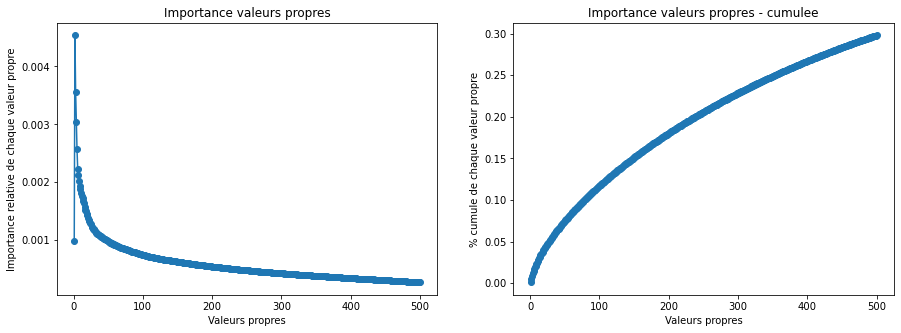

In [13]:
truncated_svd = TruncatedSVD(n_components=500)
truncated_svd.fit(x_train_tfidf)

fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121)
ax1.plot(range(1, 501), truncated_svd.explained_variance_ratio_, marker='o')
ax1.set_title('Importance valeurs propres')
ax1.set_xlabel('Valeurs propres')
ax1.set_ylabel('Importance relative de chaque valeur propre')

ax2 = fig.add_subplot(122)
ax2.plot(range(1, 501), truncated_svd.explained_variance_ratio_.cumsum(), marker='o')
ax2.set_title('Importance valeurs propres - cumulee')
ax2.set_xlabel('Valeurs propres')
ax2.set_ylabel('% cumule de chaque valeur propre')

In [32]:
truncated_svd.explained_variance_ratio_.cumsum()[420 - 1]*100

81.10764292781579

In [11]:
# We are using 420 components, which represent 81% of the dataset variance.
truncated_svd = TruncatedSVD(n_components=420)
truncated_svd.fit(x_train_tfidf)

TruncatedSVD(n_components=420)

In [ ]:
#---------------------#
#---------------------#

In [ ]:
# Choice of model:

In [40]:
x_transfo1 = tfidf_vectorizer.fit_transform(x_train)
x_transfo2 = truncated_svd.fit_transform(x_transfo1)

In [11]:
liste_model_name = []
liste_result_time = []
liste_best_score = []
liste_log_loss = []

In [14]:
# Logistic Regression

param_grid_logReg = {
    'estimator__C': np.logspace(-1, 3, 5)
}

model_logReg = GridSearchCV(
    OneVsRestClassifier(
        LogisticRegression(
            class_weight='balanced',
            multi_class='ovr'
        )
    ),
    param_grid_logReg,
    scoring='neg_log_loss',
    cv=3
)

model_logReg.fit(x_transfo2[:1000], y_train[:1000])

print('Best score: {:.2f}'.format(model_logReg.best_score_))
print('Best parameters: ', model_logReg.best_params_)

Best score: -10.89
Best parameters:  {'estimator__C': 10.0}


In [52]:
number = 2000
y_test_tmp = y_test[:number]
x_test_tmp = x_test[:number]

start = time.time()
y_pred = model_logReg.predict(truncated_svd.transform(tfidf_vectorizer.transform(x_test_tmp)))
stop = time.time()

liste_model_name.append('logReg')
liste_result_time.append(stop - start)
liste_best_score.append(model_logReg.best_score_)
liste_log_loss.append(log_loss(y_test_tmp, y_pred))

In [35]:
# SVM

param_grid_svc= {
    'estimator__C': np.logspace(-1, 2, 3),
    'estimator__kernel': ['rbf', 'sigmoid'],
}

model_svc = GridSearchCV(
    OneVsRestClassifier(
        SVC(
            class_weight='balanced',
            probability=True
        )
    ),
    param_grid_svc,
    scoring='neg_log_loss',
    cv=3
)

model_svc.fit(x_transfo2[:500], y_train[:500])

print('Best score: {:.2f}'.format(model_svc.best_score_))
print('Best parameters: ', model_svc.best_params_)

Best score: -15.95
Best parameters:  {'estimator__C': 100.0, 'estimator__kernel': 'rbf'}


In [57]:
number = 2000
y_test_tmp = y_test[:number]
x_test_tmp = x_test[:number]

start = time.time()
y_pred = model_svc.predict(truncated_svd.transform(tfidf_vectorizer.transform(x_test_tmp)))
stop = time.time()

liste_model_name.append('SVC')
liste_result_time.append(stop - start)
liste_best_score.append(model_svc.best_score_)
liste_log_loss.append(log_loss(y_test_tmp, y_pred))

In [46]:
# Random Forest

param_grid_rf = {
    'estimator__max_depth': [10, 50],
}

model_rf = GridSearchCV(
    OneVsRestClassifier(
        RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=0)
    ),
    param_grid_rf,
    scoring='neg_log_loss',
    cv=3,
    n_jobs=2
)

model_rf.fit(x_transfo2[:500], y_train[:500])

print('Best score: {:.2f}'.format(model_rf.best_score_))
print('Best parameters: ', model_rf.best_params_)

Best score: -20.07
Best parameters:  {'estimator__max_depth': 50}


In [58]:
number = 2000
y_test_tmp = y_test[:number]
x_test_tmp = x_test[:number]

start = time.time()
y_pred = model_rf.predict(truncated_svd.transform(tfidf_vectorizer.transform(x_test_tmp)))
stop = time.time()

liste_model_name.append('RF')
liste_result_time.append(stop - start)
liste_best_score.append(model_rf.best_score_)
liste_log_loss.append(log_loss(y_test_tmp, y_pred))

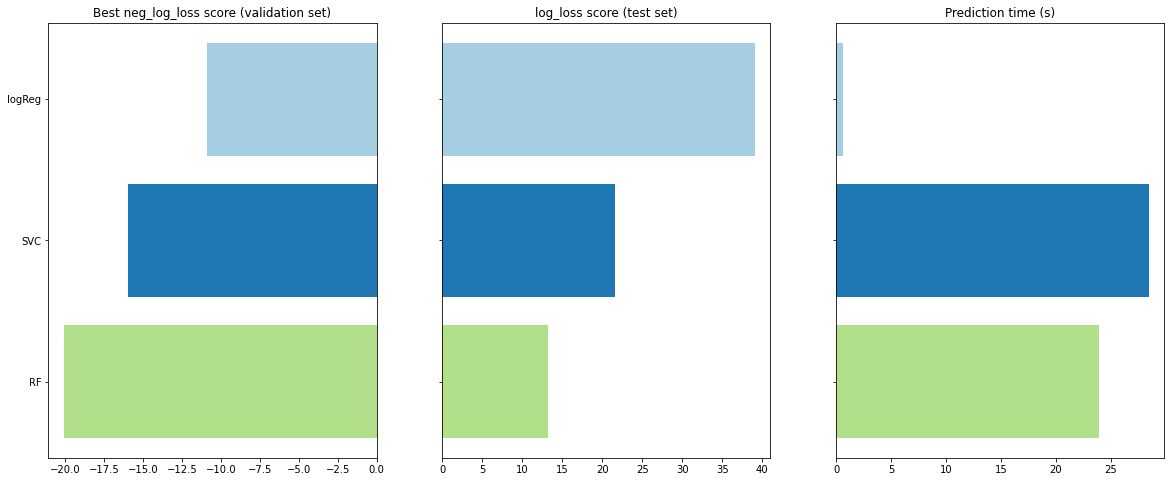

In [59]:
# Metrics - Graphic:

f, axes = plt.subplots(1, 3, figsize=(20, 8))

# negative log loss score (validation set)
axes[0].barh(liste_model_name, liste_best_score, color=plt.cm.Paired(np.arange(len(liste_model_name))))
axes[0].set_title('Best neg_log_loss score (validation set)')
axes[0].invert_yaxis()

# log loss score (test set)
axes[1].barh(liste_model_name, liste_log_loss, color=plt.cm.Paired(np.arange(len(liste_model_name))))
axes[1].set_title('log_loss score (test set)')
axes[1].set_yticklabels([])
axes[1].invert_yaxis()

# prediction time for each model
axes[2].barh(liste_model_name, liste_result_time, color=plt.cm.Paired(np.arange(len(liste_model_name))))
axes[2].set_title('Prediction time (s)')
axes[2].set_yticklabels([])
axes[2].invert_yaxis()

In [ ]:
'''
During training, the logReg model has the highest score (neg_log_loss).
Regarding the log_loss score, logReg has the worst score.
But, the prediction time is highly better for the logReg model.
Because of the worst prediction times for the two others models,
we will use the logReg model for our prediction.
'''

In [ ]:
#---------------------#
#---------------------#

In [ ]:
# Model for API : logReg

In [34]:
pipe_logReg = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_df=0.90, min_df=0.01, ngram_range=(1,3))),
    ('truncatedsvd', TruncatedSVD(n_components=420)),
    ('model', OneVsRestClassifier(
        LogisticRegression(
            class_weight='balanced',
            multi_class='ovr'
        )
    ))
])

param_grid_logReg = {
    'model__estimator__C': np.logspace(1, 3, 3)
}

model_OvR_LogReg = GridSearchCV(
    pipe_logReg,
    param_grid_logReg,
    scoring='neg_log_loss',
    cv=5
)

model_OvR_LogReg.fit(x_train, y_train)

print('Best score: {:.2f}'.format(model_OvR_LogReg.best_score_))
print('Best parameters: ', model_OvR_LogReg.best_params_)

Best score: -7.26
Best parameters:  {'model__estimator__C': 10.0}


In [ ]:
#---------------------#

In [ ]:
# F1 and Jaccard score

In [20]:
def create_liste_result_f1_jaccard(x, model, threshold):
    y_pred = model.predict_proba(x)

    liste_result_y_pred = []

    for index in range(len(y_pred)):
        result_y_pred = [0] * len(y_pred[index])
        tmp_y_pred = [a for a, b in enumerate(y_pred[index]) if b >= threshold]

        for i in range(len(tmp_y_pred)):
            result_y_pred[tmp_y_pred[i]] = 1

        liste_result_y_pred.append(result_y_pred)

    return(liste_result_y_pred)

In [21]:
def f1_jaccard_graph(x, y, model):

    result_threshold = []
    result_f1 = []
    result_jaccard = []

    for i in range(0, 50, 1):
        seuil = i/50
        liste_result_y_pred = create_liste_result_f1_jaccard(x, model, seuil)

        result_threshold.append(seuil)
        result_f1.append(f1_score(y, liste_result_y_pred, average='weighted'))
        result_jaccard.append(jaccard_score(y, liste_result_y_pred, average='weighted'))

    fig, ax1 = plt.subplots(figsize=(10, 7))

    color = 'tab:red'
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('F1 score (weighted)', color=color)
    ax1.plot(result_threshold, result_f1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()

    color = 'tab:blue'
    # we already handled the x-label with ax1
    ax2.set_ylabel('Jaccard score (weighted)', color=color)
    ax2.plot(result_threshold, result_jaccard, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # otherwise the right y-label is slightly clipped
    fig.tight_layout()
    plt.show()

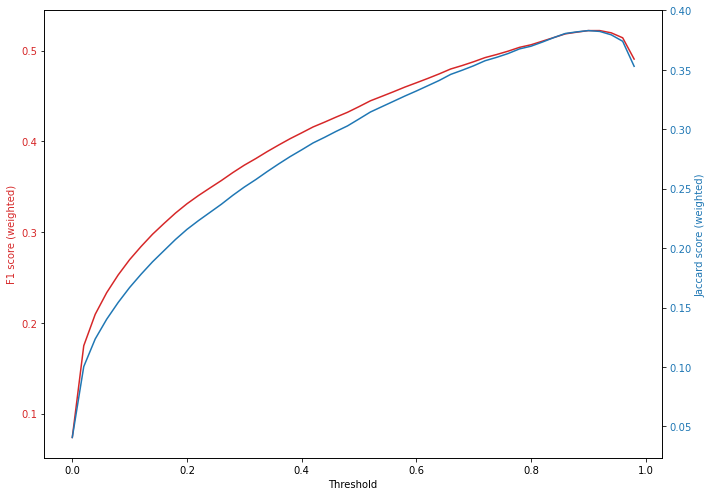

In [31]:
# F1, jaccard -> average = weighted
f1_jaccard_graph(x_test[:5000], y_test[:5000], model_OvR_LogReg)

In [13]:
from sklearn.metrics import precision_score, recall_score

In [43]:
# The max (for F1 and Jaccard scores) is near to a threshold ~ 0.9
def max_scores(x, y, model):

    result_threshold = []
    result_f1 = []
    result_jaccard = []
    result_prec = []
    result_recall = []

    # Thnaks to the graph, we know that the max of Jaccard score
    # is given by a threshold > 0.80
    for i in range(80, 100, 1):
        seuil = i/100
        liste_result_y_pred = create_liste_result_f1_jaccard(x, model, seuil)

        result_threshold.append(seuil)
        result_jaccard.append(jaccard_score(y, liste_result_y_pred, average='weighted'))
        result_f1.append(f1_score(y, liste_result_y_pred, average='weighted'))        
        result_prec.append(precision_score(y, liste_result_y_pred, average='weighted'))
        result_recall.append(recall_score(y, liste_result_y_pred, average='weighted'))

    # we want to maximize the Jaccard score:
    index = result_jaccard.index(max(result_jaccard))
    
    print("Threshold = ", result_threshold[index])
    print("\nScores (average == weighted):\n")
    print("Jaccard score    = {:.2f}".format(result_jaccard[index]))
    print("F1 score         = {:.2f}".format(result_f1[index]))
    print("Precision score  = {:.2f}".format(result_prec[index]))
    print("Recall score     = {:.2f}".format(result_recall[index]))

In [74]:
max_scores(x_test[:5000], y_test[:5000], model_OvR_LogReg)

Threshold =  0.9

Scores (average == weighted):

Jaccard score    = 0.38
F1 score         = 0.52
Precision score  = 0.49
Recall score     = 0.60


In [ ]:
'''
In order to maximize the score,
we will use : threshold = 0.90

Besides, in the previous notebook, we showed the scores for our LDA.
The LDA (tested with 30 sentences) had those results:
    Jaccard score (weighted) = 0.25
    F1 score (weighted)      = 0.35

Here, the logistic regression reaches these scores:
    Jaccard score (weighted) = 0.38
    F1 score (weighted)      = 0.52

Our supervised algorithm is better than our unsupervised model in order to predict tags.

For the logistic regression, the F1 score could confirm that
the algorithm was able to manage the imbalance in the tags distribution.
'''

In [ ]:
#---------------------#

In [ ]:
# Test with sentences

In [29]:
new_review1 = ['Hello! I want to create a model, which can give the tags of a sentence or question. Besides, I have to try both supervised and unsupervised machine learning algorithms. Do you know some python librairies, which can help building fast models?']

new_review2_title = ["Finding duplicate values in a SQL table"]
new_review2 = ["It's easy to find duplicates with one field. So if we have a table. This query will give us John, Sam, Tom, Tom because they all have the same email. However, what I want is to get duplicates with the same email and name. That is, I want to get 'Tom', 'Tom'. The reason I need this: I made a mistake, and allowed to insert duplicate name and email values. Now I need to remove/change the duplicates, so I need to find them first."]

new_review3_title = ["How to make several plots on a single page using matplotlib?"]
new_review3 = ["I have written code that opens 16 figures at once. Currently they all open as separate graphs. I'd like them to open all on the same page. Not the same graph. I want 16 separate graphs on a single page/window. Also for some reason the format of the numbins and defaultreallimits doesn't hold past figure 1. Do I need to use the subplot command? I don't understand why I would have to but can't figure out what else I would do?"]

new_review4 = ['is it possible to increase the ram in google colab with another way?']

In [34]:
# We are using predict_proba to get a prediction probability for each tag encoded.
# If the tag probability is higher than the threshold
# then it will be transform by the "inverse transform" function of the label encoder
# it will show the tags predicted for the sentence

array = model_OvR_LogReg.predict_proba(new_review1)

threshold = 0.90

print(le.inverse_transform([i for i, j in enumerate(array[0]) if j >= threshold]))

['machine-learning' 'python' 'python-3.x']


In [36]:
array = model_OvR_LogReg.predict_proba(new_review4)

threshold = 0.90

print(le.inverse_transform([i for i, j in enumerate(array[0]) if j >= threshold]))

['google-cloud-platform' 'google-colaboratory']


In [ ]:
#---------------------#

In [ ]:
# We have to save the algorithms
# in order to create the API

In [26]:
# Saving models
with open('../flask_api_git/models/logreg/'+ 'model_ovr_reglog_v2.pk', 'wb') as file:
	pickle.dump(model_OvR_LogReg, file)

with open('../flask_api_git/models/logreg/'+ 'multiLabel_binarizer.pk', 'wb') as file:
	pickle.dump(mlb, file)

with open('../flask_api_git/models/logreg/'+ 'label_encoder.pk', 'wb') as file:
	pickle.dump(le, file)